# Imports

In [1]:

import pandas as pd
import numpy as np
import math
from itertools import product
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt

import os

In [2]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                 names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df.set_index('time', inplace=True)
df.index = pd.DatetimeIndex(df.index * 1e+9)

In [3]:
len(df)

80826

In [4]:
class Trader1:
    # Bollinger: https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/#:~:text=Using%20the%20bands%20as%20overbought,have%20deviated%20from%20the%20mean.
    def __init__(self, n_cycles, n_devs, qty, take_at=0.005, fee=0.0026):
        # qty = quantity to trade at a time
        # EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier)
        # 
        # BOLU=MA(TP,n)+m∗σ[TP,n]
        # BOLD=MA(TP,n)−m∗σ[TP,n]
        # where:
        # BOLU=Upper Bollinger Band
        # BOLD=Lower Bollinger Band
        # MA=Moving average
        # TP (typical price)=(High+Low+Close)÷3
        # n=Number of cycles in smoothing period ... n_cycles
        # m=Number of standard deviations ... n_devs
        # σ[TP,n]=Standard Deviation over last n periods of TP
        #
        # take_at = take profit at p0 * (1 + someting% + 2*fee)
        self.N = n_cycles
        self.M = n_devs
        self.qty = qty
        self.take_at = take_at
        self.fee = fee
        self.prices = np.array([0.] * self.N)
        
        self.sma = None
        self.upper = None
        self.lower = None
        self.var = None
        self.std = None
        self.open_price = None
        self.profit_price = None
        self.loss_price = None
    
        self.position = 0
        self.trades = []
        
        self.warming_up = True
        self.i = 0
    
    def update(self, cycle, ohlc: dict, price):
        _, high, low, close = self._unpack(ohlc)

        last_price = self.prices[self.i]
        self.prices[self.i] = price
        self.i += 1
        if self.i == len(self.prices):
            self.i = 0
            if self.warming_up:
                self.warming_up = False
                self.sma = np.mean(self.prices)
                self.var = np.var(self.prices)
                self.std = math.sqrt(self.var)
                self.upper = self.sma + self.M * self.std
                self.lower = self.sma - self.M * self.std
                return

        if not self.warming_up:
            old_sma = self.sma
            self.sma += (price - last_price) / self.N
            self.var += (price - self.sma + last_price - old_sma)*(price - last_price)/(self.N)
            self.var = self.check_var(self.var)
            self.std = math.sqrt(self.var)
            self.upper = self.sma + self.M * self.std
            self.lower = self.sma - self.M * self.std
            
    def check(self, x):
        if np.abs(x) > 0.01:
            raise
    
    def check_var(self, var):
        if var < 0:
            if abs(var) >= 1.e-4:
                raise Exception(f'var was {var}')
            return 0.
        return var
    
    def trade(self) -> float:  # return number of shares to trade
        if self.warming_up:
            return None
        price = self.prices[self.i]
        # buy
        if price < self.lower and self.position <= 0:
            if self.position == 0:
                self.open_price = price
                self.profit_price = price + self.take_at + 2*self.fee
                self.loss_price = price - (self.take_at + 2*self.fee)
            self.position += self.qty
            return self.qty
    
        # sell
        if price > self.upper and self.position >= 0:
            if self.position == 0:
                self.open_price = price
                self.loss_price = price + self.take_at + 2*self.fee
                self.profit_price = price - (self.take_at + 2*self.fee)
            self.position -= self.qty
            return -self.qty
        
        # profit
        if self.position > 0:
            if not self.loss_price <= price <= self.profit_price:
                self.position -= self.qty
                return -self.qty
        elif self.position < 0:
            if not self.profit_price <= price <= self.loss_price:
                self.position += self.qty
                return +self.qty
    
    @staticmethod
    def _unpack(ohlc: dict):
        return ohlc['open'], ohlc['high'], ohlc['low'], ohlc['close']

# DcatTrader

In [172]:
# Model that assumes we have aggregated information from the future
class DcatTrader:
    def __init__(self, window, actual_prices, take_min, qty, fee):
        self.y = self.get_y2(window, actual_prices)
        self.i = -1
        self.position = 0
        self.entry_price = 0
        self.price = 0
        self.take_min = take_min
        self.qty = qty
        self.fee = fee
        
    def update(self, _, __, price):
        self.i += 1
        self.price = price
        
        pass
    
    def trade(self):
        if np.isnan(self.y[self.i]):
            return
        
        # effective pnl% in terms of return r:
        #    pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
        #                 = r*(sign(q) - f) - 2*fee
        
        t = self.take_min
        f = self.fee
        if self.position == 0:
            r = self.y[self.i]
            
            is_good_buy = r >= (t+2*f)/(1-f)
            is_good_sell = r <= -(t+2*f)/(1+f)
        else:
            r = (self.price - self.entry_price)/self.entry_price
            
            is_good_buy = self.position < 0 and r <= -(t+2*f)/(1+f)
            is_good_sell = self.position > 0 and r >= (t+2*f)/(1-f)
            
        if is_good_buy:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position += self.qty  
            return self.qty
        elif is_good_sell:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position -= self.qty 
            return -self.qty          
            
        return 0
    
    def get_y2(self, w, prices):
                
        ma = prices.iloc[::-1].rolling(w).max()
        mi = prices.iloc[::-1].rolling(w).min()
        s = (ma + mi).iloc[::-1]
        return (.5*(s - 2.*prices)/prices)

In [180]:
def trade(df, model):
    # model needs to have .update(cycle, ohlc) and trade()
    # return the trades

    trades = pd.DataFrame(index=df.index)
    trades['qty'] = [0.] * len(trades)
    
    for i, (cycle, ohlc) in enumerate(df.iterrows()):
        model.update(cycle, ohlc, ohlc['close'])
        qty = model.trade()
        if qty:
            trades.iloc[i] = qty
    return trades

def account(prices, trades, fee=0.0026):
    #prices = df.open
    volume = prices * trades.qty * (1 + np.sign(trades.qty) * fee)

    last_price = prices.iloc[-1]
    qty_to_liquidate = -trades.qty.sum()
    last_volume = last_price * qty_to_liquidate * (1 + np.sign(qty_to_liquidate) * fee)

    pnl = -(last_volume + volume.sum())
    
    return pnl

def cycle_realized_pnl(prices, trades, fee=0.0026):
    #prices = df.open.shift(-1, fill_value=df.open.iloc[-1])
    volume = prices * trades.qty * (1 + np.sign(trades.qty) * fee)
    
    values = pd.DataFrame(index=prices.index, columns=['pnl', 'adjusted_pnl']).fillna(0.)
    v = 0.
    position = 0.
    max_position = 0.
    open_price = 0.
    for i, qty in enumerate(trades.qty):
        was_open = position != 0
        
        position = round(position + qty, 8)
        max_position = max(abs(position), max_position)
        v -= volume.iloc[i]
        
        if not was_open and position != 0:
            open_price = prices[i]
        
        if position == 0:
            if was_open:
                market_pnl = max_position * abs(prices[i] - open_price)
                #market_pnl -= fee * max_position * (prices[i] + open_price)
                values.iloc[i] = (v, v - market_pnl)
            v = 0
            max_position = 0
            
    if position:
        last_price = prices.iloc[-1]
        assert np.isclose(position, trades.qty.sum()), f'position={position}, trades.qty.sum()={trades.qty.sum()}'
        qty_to_liquidate = -position
        last_volume = last_price * qty_to_liquidate * (1 + np.sign(qty_to_liquidate) * fee)
        assert values.iloc[-1][0] == 0
        
        market_pnl = max_position * abs(prices[i] - open_price)
        #market_pnl -= fee * max_position * (prices[i] + open_price)
        values.iloc[i] = (-last_volume + v, -last_volume + v - market_pnl)
        
        #values.iloc[-1] = -last_volume + v
    return values

def robustness(pnls, prices):
    # It should tell how much the model depends on the market
    returns = (prices.shift(-1) - prices)/prices
    idx = pnls != 0
    a = pnls[idx][:-1].corr(prices[idx][:-1])
    return 1 - a*a


def sharpe(pnls):
    return np.sum(pnls) / np.std(pnls)

def test_account():
    #df = pd.DataFrame({'open': [10,11,12,13,14]})
    #prices = df['open'].shift(-1, fill_value=df.open.iloc[-1])
    prices = pd.Series([11,12,13,14,14])
    
    trades = pd.DataFrame({'qty': [1,-1,1,0,0]})
    fee = 1
    a = cycle_realized_pnl(prices, trades, fee=fee).pnl.sum()
    b = account(prices, trades, fee=fee)
    assert a == b
    assert a == -48.
    c = cycle_realized_pnl(prices, trades, fee=fee).adjusted_pnl.sum()
    assert c == -50., f'c = {c}'

test_account()

# Run Sim

In [188]:
trades = trade(df, Trader1(10, 2, 0.002))
acc = cycle_realized_pnl(df, trades)
sharpe(acc.pnl), sharpe(acc.adjusted_pnl)

(-17652.73139847319, -17980.460262671964)

In [182]:
trades = trade(df, DcatTrader(75, actual_prices=df.close,
                              take_min=0.005, qty=0.002, fee=0.0026))
acc = cycle_realized_pnl(df.close, trades)
rob = robustness(acc.pnl, df.close)
sharpe(acc.pnl), len(acc.pnl[acc.pnl < 0]), len(acc.pnl[acc.pnl > 0]), rob
# (6058.5075476589045, -8191.272070021878), (33, 1103)

(10046.515901276536, 0, 1925, 0.5805772782733891)

(0, 1925)

In [126]:
acc.pnl[acc.pnl < 0].head(1)

time
2020-01-21 18:58:00   -0.002824
Name: pnl, dtype: float64

In [158]:
r = -0.005
fee = 0.003
qty = -0.0002

# pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
r*np.sign(qty) - fee*(2+r)

-0.0009850000000000006

In [164]:
for i in [30]:
    fee = 0.0001 * i
    print(fee, (0.005 + 2*fee)/(1-fee), -(0.005 + 2*fee)/(1+fee))

0.003 0.011033099297893681 -0.010967098703888336


In [166]:
0.010967098703888336 - fee * (2 -0.010967098703888336)

0.005000000000000001

In [147]:
(8652.87 * (1-0) - 8609.40 * (1+0))*0.002

0.08694000000000233

In [223]:
trades.loc['2020-02-17 16:50:00']

qty   -0.002
Name: 2020-02-17 16:50:00, dtype: float64

In [225]:
prices.open['2020-02-17 16:50:00']

9728.42

In [127]:
a = pd.merge(trades, df, left_index=True, right_index=True)
a = pd.merge(a, acc, left_index=True, right_index=True)
a = a[a.qty!=0]

In [136]:
b = a.query('time <= "2020-01-21 18:58:00" and time >= "2020-01-21 03:21:00"')
b

,qty,open,high,low,close,volume,trades,pnl,adjusted_pnl
time,,,,,,,,,
2020-01-21 03:21:00,-0.002,8652.87,8652.87,8652.87,8652.87,0.014690,1,0.000000,0.000000
2020-01-21 18:58:00,0.002,8609.40,8609.40,8609.40,8609.40,0.007497,1,-0.002824,-0.089764


In [139]:
cycle_realized_pnl(b.close, b, fee=0)

,pnl,adjusted_pnl
time,,
2020-01-21 03:21:00,0.00000,0.000000e+00
2020-01-21 18:58:00,0.08694,3.233525e-15


# Plotting

In [47]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as offline

def plot(df, trades):
    # df columns = ['open', 'high', 'low', 'close', 'volume', 'trades']
    # trades columns = ['qty']

    buys = df.open[trades.qty > 0]
    sells = df.open[trades.qty < 0]
    pnls = cycle_realized_pnl(df, trades).pnl
    pnls = pnls[pnls != 0]
    pnls = pnls.cumsum()
    
    trace = go.Scatter(
        x=df.index,
        y=df['open'],
        name='Tick'
    )

    trace2 = go.Scatter(
        x=buys.index,
        y=buys,
        #text=buys['order_id'],
        #hoverinfo='text',
        name='Buy',
        mode='markers',
        marker=dict(
            size=10,
            color='rgba(182, 255, 193, .9)',
            line=dict(
                width=2,
            )
        )
    )

    trace3 = go.Scatter(
        x=sells.index,
        y=sells,
        #text=sells['order_id'],
        #hoverinfo='text',
        name='Sell',
        mode='markers',
        marker=dict(
            size=7,
            color='rgba(255, 182, 193, .9)',
            line=dict(
                width=1,
            )
        )
    )

    trace4 = go.Scatter(
        x=pnls.index,
        y=pnls,
        name='P&L',
        mode='lines+markers',
        marker=dict(
            size=5,
            color='rgba(193, 182, 255, .9)',
            line=dict(
                width=1,
            )
        ),
        yaxis='y2'
    )
    
    data = [trace, trace2, trace3, trace4]
    layout = go.Layout(
        title='Trading log',
        yaxis=dict(
            title='Price'
        ),
        yaxis2=dict(
            title='BTC',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        ),
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        ),
        xaxis2=dict()
    )

    fig = go.Figure(data=data, layout=layout)
    offline.plot(fig, auto_open=True, filename=os.path.join('/Users/felipe/crypto/bitme2', 'results_plot.html'))
    # offline.iplot(fig)  #

    return 0

In [48]:
plot(df, trades)

0

# Model research

In [189]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                     names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df = df.set_index('time')
df.index = pd.DatetimeIndex(df.index * 1e+9)
#df = df.reindex(index=pd.date_range(df.index[0], df.index[-1],
#                        freq=pd.Timedelta('00:01:00')), method='ffill', copy=False)

In [195]:
# definition of returns for research is different:
returns = (df.close - df.open) / df.open
prices = df.close

In [191]:
len(df)

80826

In [192]:
def get_y(w, prices):
    ma = prices.iloc[::-1].rolling(w).max()
    mi = prices.iloc[::-1].rolling(w).min()
    s = (ma + mi).iloc[::-1]
    return (.5*(s - 2.*prices)/prices).shift(-1)

def get_lagged_y(w, prices):
    ma = prices.rolling(w).max()
    mi = prices.rolling(w).min()
    s = (ma + mi)
    return (.5*(s - 2.*prices)/prices)    

## volatility per interval

In [ ]:
interval_std = {}
for interval in (2, 5, 30, 60, 120, 300, 24*60, 7*24*60):
    interval_std[interval] = (returns - returns.rolling(interval, center=True).mean()).abs().std()

In [ ]:
returns.abs().mean()

In [ ]:
interval_std

In [ ]:
30/61000

In [ ]:
returns.iloc[-100:].plot()

In [ ]:
returns.std()

* Conclusion: they are all about the same

## Optimal interval

It should be the interval that the lagged Y predicts Y

## cost and get_x_y

In [631]:
def apply_threshold(s, threshold):
    s[s.abs() < threshold] = np.nan

# Cost function
def cost(prices, returns):
   
    def _helper(args):
        lookback, lookahead = (int(i) for i in args)
        if lookback <= 0 or lookahead <= 0:
            return float('inf')
        left = get_lagged_y(lookback, prices)
        y = get_y(lookahead, prices)
        #return -(left.corr(y)**2)
        return -left.corr(-y)
    return _helper

# features
def get_x_y(prices, returns, lookback, lookahead):
    lag_y = get_lagged_y(lookback, prices)
    return pd.DataFrame({
        'mean_ret': returns.rolling(lookback).mean(),
        #'dmean': returns.diff().rolling(lookback).mean(),
        #'d2mean': returns.diff().diff().rolling(lookback).mean(),
        #'volatility': returns.rolling(lookback).std(),
        #'lagged_y': lag_y,
        'min': returns.rolling(lookback).min(),
        'max': returns.rolling(lookback).max(),
        #'ewm': returns.ewm(span=lookback).mean(),
        #'acce': returns.diff().ewm(span=lookback).mean(),
        'y': get_y(lookahead, prices),
    }, index=returns.index).dropna().astype(float)

def get_acceleration(prices, returns, lookback, lookahead):
    lag_y = get_lagged_y(lookback, prices)
    y = get_y(lookahead, prices)
    return pd.DataFrame({
        #'ewm': returns.ewm(span=lookback).mean(),
        'ewm': returns.rolling(lookback).sum()* (-0.08263353),
        'y': y
    }, index=returns.index)

# cost function
def get_acc_cost(prices, returns, lookback, lookahead, threshold=5e-3):
    a = get_acceleration(prices, returns, lookback, lookahead).dropna()
    original_len = len(a)
    #apply_threshold(a['ewm'], threshold)
    apply_threshold(a['y'], threshold)
    a = a.dropna()
    return (a['ewm'].corr(a['y'])) *1# (len(a)/ original_len)

In [573]:
results = {}
for i in range(25):
    lookback = int((i+2)**(1.5)) or int((i+2)**(2.1))
    for j in range(i):
        lookahead = int((i+2)**(1.5)) or int((j+2)**(2.1))
    #a = get_acceleration(prices, returns, lookback, 10)
        results[(lookback, lookahead)] = get_acc_cost(prices, returns, lookback, lookahead)

In [537]:
sorted(results.items(), key=lambda x: results[x[0]], reverse=True)[:5]

[((22, 22), 0.15471246277159267),
 ((27, 27), 0.14932637278852604),
 ((18, 18), 0.14049780145909027),
 ((31, 31), 0.12084589488209524),
 ((14, 14), 0.08814238051225154)]

In [544]:
get_acc_cost(prices, returns, 30, 30)

0.12899072817015206

In [448]:
a = get_acceleration(prices, returns, 125, 75)
apply_threshold(a['ewm'], 1e-3)
a.dropna().size

39616

### Best ewm span: 6200 with 72%

## optmize with scipy

In [235]:
from scipy.optimize import minimize

In [250]:
x0 = [150, 150]

In [638]:
res = minimize(cost(prices, returns), x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

res

Optimization terminated successfully.
         Current function value: 0.008912
         Iterations: 52
         Function evaluations: 160


 final_simplex: (array([[  2.01295406, 313.02955896],
       [  2.01295406, 313.02955896],
       [  2.01295406, 313.02955896]]), array([0.00891223, 0.00891223, 0.00891223]))
           fun: 0.008912227887888076
       message: 'Optimization terminated successfully.'
          nfev: 160
           nit: 52
        status: 0
       success: True
             x: array([  2.01295406, 313.02955896])

In [257]:
cost(prices, returns)([2000, 1000])

0.034295217971387584

In [ ]:
results = {}

In [ ]:
%%time
args = []
for lookback in range(50,101):
    for lookahead in range(50,101):
        args.append((lookback, lookahead))
for i in trange(len(args)):
    results[args[i]] = cost(returns)( args[i] )

In [ ]:
sorted(results.items(), key=lambda x: results[x[0]])

### Conclusion: 75 mins lookback sum predicts 75 forward with 58% confident

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection

In [526]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [632]:
X_train = get_x_y(prices, returns, 30, 30).dropna()
y_train = X_train[['y']]
X_train = X_train.drop('y', axis=1)

train_size = int(0.80 * len(X_train))
test_size = len(X_train) - train_size

X_test = X_train.iloc[train_size:-1]
y_test = y_train.iloc[train_size:-1]

X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]

In [633]:
regr.fit(X_train, y_train)
print(regr.coef_)
regr.score(X_test, y_test)

[[-3.32801942  0.04858423  0.02541414]]


-0.016188450006520583

In [647]:
def s_sign(s):
    s = s.copy()
    s[s < 0] = -1
    s[s > 0] = 1
    return s

In [637]:
y_train.y.corr(pd.Series(regr.predict(X_train)[:,0], index=y_train.index)),\
y_test.y.corr(pd.Series(np.clip(regr.predict(X_test)[:,0], -5e-4,5e-4), index=y_test.index))

(0.12142170537456645, -0.025109446383995666)

In [650]:
y_train.y.corr(pd.Series(regr.predict(X_train)[:,0], index=y_train.index)),\
s_sign(y_test.y).corr(pd.Series(np.sign(regr.predict(X_test)[:,0]), index=y_test.index))

(0.12142170537456645, -0.00599533041070667)

In [662]:
pd.Series(np.random.normal(size=1000)).corr(pd.Series(np.random.normal(size=1000)))

-0.0069807297041690934

## Model selection

In [641]:
X = get_x_y(prices, returns, 30, 30)

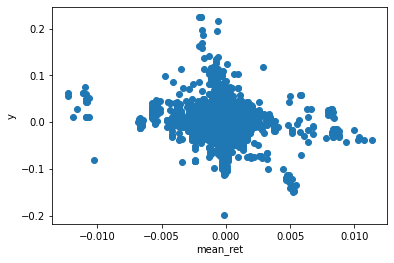

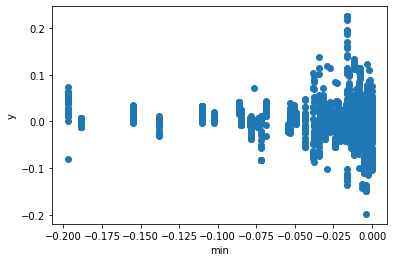

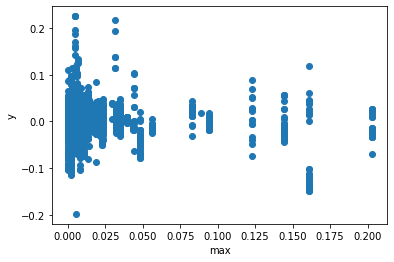

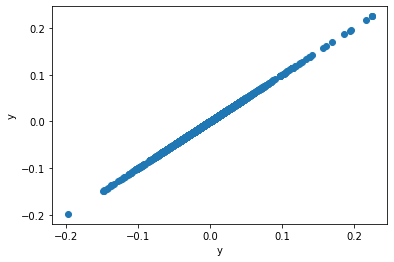

In [642]:
for index, feature_name in enumerate(X.columns):
#for index, feature_name in enumerate(['sum']):
    if feature_name != 'z':
        plt.figure()
        plt.scatter(X.iloc[:, index], X.y) 
        plt.xlabel(feature_name)
        plt.ylabel("y")

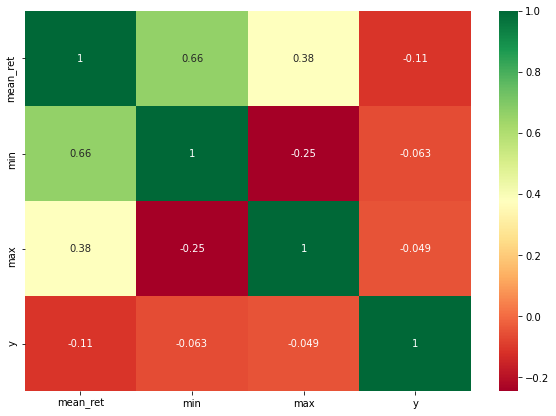

In [643]:
import pandas as pd
import numpy as np
import seaborn as sns
#data = pd.read_csv("D://Blogs//train.csv")
#X = data.iloc[:,0:20]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,7))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [577]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y.values,
                            test_size=0.25)

for Model in [GaussianNB, KNeighborsClassifier, LinearSVC]:
    clf = Model().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('%s: %s' %
          (Model.__name__, metrics.f1_score(y_test, y_pred, average="macro")))  


NameError: name 'model_selection' is not defined